<a href="https://colab.research.google.com/github/j28302830/Senior_Project/blob/main/reconized_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Samples and Models file

In [86]:
!wget http://dataset.tlm.unavarra.es/ransomware/samplesAndModels.tar.xz
!tar -Jxvf /content/samplesAndModels.tar.xz &> /dev/null

--2022-05-16 11:08:35--  http://dataset.tlm.unavarra.es/ransomware/samplesAndModels.tar.xz
Resolving dataset.tlm.unavarra.es (dataset.tlm.unavarra.es)... 130.206.160.87
Connecting to dataset.tlm.unavarra.es (dataset.tlm.unavarra.es)|130.206.160.87|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41519408 (40M) [application/x-xz]
Saving to: ‘samplesAndModels.tar.xz.2’

samplesAndModels.ta 100%[===================>]  39.60M  9.70MB/s    in 4.7s    

2022-05-16 11:08:40 (8.45 MB/s) - ‘samplesAndModels.tar.xz.2’ saved [41519408/41519408]



# Import Package

In [87]:
import tensorflow as tf
import keras
import glob
import numpy as np
from pickle import load
import joblib 

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predefined Function

In [88]:
def load_sample(local_path):
  filenames = glob.glob(local_path + "/*.txt")
  for i,filename in enumerate(filenames):
    if i == 0:
      x = np.loadtxt(filename, delimiter=',', dtype = 'float32')
    else: 
      ds = np.loadtxt(filename, delimiter=',', dtype = 'float32')
      x = np.concatenate((x, ds), axis=0)

  return x

In [89]:
def metrics(model , x, y):
  predict = model.predict(x)
  predict[predict >= 0.99] = 1
  predict[predict < 0.99] = 0

  true_values = y
  predictions = predict

  TP = ((predictions == 1) & (true_values == 1)).sum()
  FP = ((predictions == 1) & (true_values == 0)).sum()
  TN = ((predictions == 0) & (true_values == 0)).sum()
  FN = ((predictions == 0) & (true_values == 1)).sum()

  accuracy = (TP+TN) / (TP+FP+TN+FN)
  precision = TP / (TP+FP)
  recall = TP / (TP+FN)
  f_measure = 2*(precision*recall/(precision+recall))
  temp = ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))** 0.5
  phi_coefficient = (TP*TN-FP*FN) / temp
  
  mat = confusion_matrix(true_values,predictions)

  print("accuracy score:", accuracy_score(true_values, predictions))
    
  sns.heatmap(mat,square= True, annot=True, cbar= False)
  plt.xlabel("predicted value")
  plt.ylabel("true value")
  plt.show()
  
  evaluate = model.evaluate(x=x, y=y)

  return [evaluate[1], accuracy, precision, recall, f_measure, phi_coefficient]

In [90]:
def scale(feature):
  scaler = joblib.load('/content/scaler.scaler')
  feature_scaled = scaler.transform(feature)
  feature_scaled_10X3 = np.reshape(feature_scaled, (feature_scaled.shape[0], 10, 3))
  return feature_scaled, feature_scaled_10X3

# Load NN, CNN, and LSTM model

In [91]:
model_NN = tf.keras.models.load_model('/content/NN_CNN_LSTM_Comparison/NN')
model_CNN = tf.keras.models.load_model('/content/NN_CNN_LSTM_Comparison/CNN')
model_LSTM = tf.keras.models.load_model('/content/NN_CNN_LSTM_Comparison/LSTM')

JSON

In [92]:
json_file = open('/content/NN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load sample

In [93]:
index = list(range(0, 30)) #show range of feature index 
test = load_sample(local_path = r'/content/samples/ransomwareSamples_test')
train = load_sample(local_path = r'/content/samples/ransomwareSamples_train')
all_ransomware = np.concatenate( (train, test), axis = 0 )
day_zero = np.loadtxt('/content/samples/userSamples/day0.txt', delimiter=',', dtype = 'float32')

# Preprocessing Sample and Run Model 

### day0 and all ransomware sample

In [94]:
label = np.delete(all_ransomware, index + [31], axis=1)
feature = np.delete(all_ransomware, [30,31], axis=1)


label2 = np.delete(day_zero, index, axis=1)
feature2 = np.delete(day_zero, [30], axis=1)

label = np.concatenate( (label, label2), axis = 0 )
feature = np.concatenate( (feature, feature2), axis = 0 )

feature_scaled, feature_scaled_10X3 = scale(feature)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


accuracy score: 0.9661494324461659


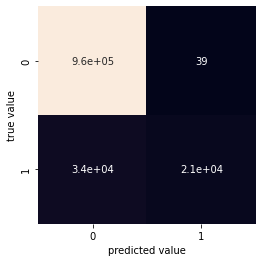

31611/31611 [==============================] - 66s 2ms/step - loss: 1.8139 - accuracy: 0.9668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


accuracy score: 0.9655958178370673


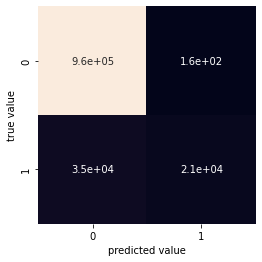

31611/31611 [==============================] - 56s 2ms/step - loss: 0.4569 - accuracy: 0.9664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


accuracy score: 0.9655730800941936


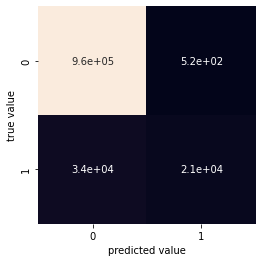

31611/31611 [==============================] - 116s 4ms/step - loss: 0.4148 - accuracy: 0.9658
NN:
accuracy(): 0.966149
CNN:
accuracy(): 0.965596
LSTM:
accuracy(): 0.965573


In [95]:
NN = metrics(model_NN, x=feature_scaled, y=label)
CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)
print("NN:\naccuracy(): %f" %NN[1] )
print("CNN:\naccuracy(): %f" %CNN[1] )
print("LSTM:\naccuracy(): %f" %LSTM[1] )

### test sample without low activity data

In [96]:
label = np.delete(test, index + [31], axis=1)
feature = np.delete(test, [30,31], axis=1)

count = np.count_nonzero(feature == 0, axis=1)
low_activity = np.where( count >= (feature.shape[1]/3) )

label = np.delete(label, low_activity, axis=0)
feature = np.delete(feature, low_activity, axis=0)

feature_scaled, feature_scaled_10X3 = scale(feature)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


accuracy score: 0.952518756698821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


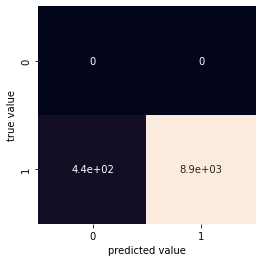

292/292 [==============================] - 1s 2ms/step - loss: 0.2123 - accuracy: 0.9735
accuracy score: 0.9371918542336549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


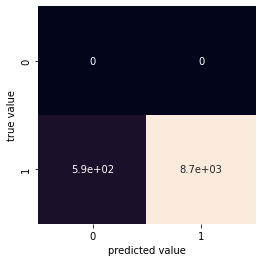

292/292 [==============================] - 1s 2ms/step - loss: 0.0818 - accuracy: 0.9772
accuracy score: 0.9468381564844587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


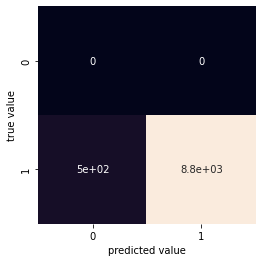

292/292 [==============================] - 1s 4ms/step - loss: 0.1293 - accuracy: 0.9803
NN:
accuracy(): 0.952519
CNN:
accuracy(): 0.937192
LSTM:
accuracy(): 0.946838


In [97]:
NN = metrics(model_NN, x=feature_scaled, y=label)
CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)
print("NN:\naccuracy(): %f" %NN[1] )
print("CNN:\naccuracy(): %f" %CNN[1] )
print("LSTM:\naccuracy(): %f" %LSTM[1] )

### train sample

In [98]:
label = np.delete(train, index + [31], axis=1)
feature = np.delete(train, [30,31], axis=1)

feature_scaled, feature_scaled_10X3 = scale(feature)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


accuracy score: 0.9860303687635574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


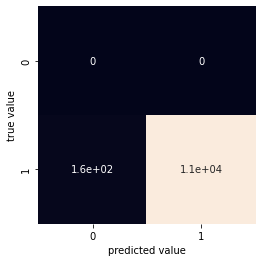

361/361 [==============================] - 1s 2ms/step - loss: 0.0337 - accuracy: 0.9956
accuracy score: 0.9840347071583514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


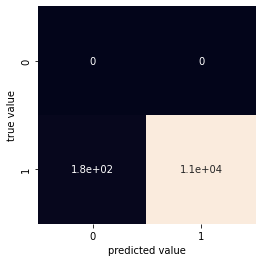

361/361 [==============================] - 1s 2ms/step - loss: 0.0240 - accuracy: 0.9946
accuracy score: 0.9742299349240781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


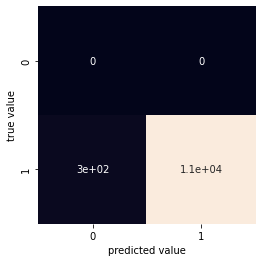

361/361 [==============================] - 1s 4ms/step - loss: 0.0799 - accuracy: 0.9894
NN:
accuracy(): 0.986030
CNN:
accuracy(): 0.984035
LSTM:
accuracy(): 0.974230


In [99]:
NN = metrics(model_NN, x=feature_scaled, y=label)
CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)
print("NN:\naccuracy(): %f" %NN[1] )
print("CNN:\naccuracy(): %f" %CNN[1] )
print("LSTM:\naccuracy(): %f" %LSTM[1] )

### all ransomware sample

In [100]:
index = list(range(0, 30))

label = np.delete(train, index + [31], axis=1)
feature = np.delete(train, [30,31], axis=1)

label2 = np.delete(test, index + [31], axis=1)
feature2 = np.delete(test, [30,31], axis=1)

label = np.concatenate( (label, label2), axis = 0 )
feature = np.concatenate( (feature, feature2), axis = 0 )

count = np.count_nonzero(feature == 0, axis=1)
low_activity = np.where( count >= (feature.shape[1]/3) )

label = np.delete(label, low_activity, axis=0)
feature = np.delete(feature, low_activity, axis=0)

feature_scaled, feature_scaled_10X3 = scale(feature)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


accuracy score: 0.971038120354831


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


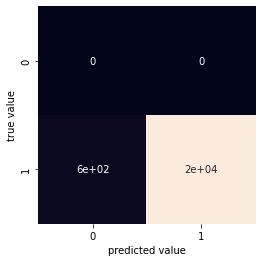

652/652 [==============================] - 1s 2ms/step - loss: 0.1136 - accuracy: 0.9857
accuracy score: 0.9630783984655957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


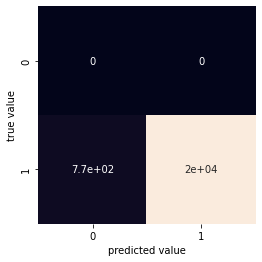

652/652 [==============================] - 1s 2ms/step - loss: 0.0499 - accuracy: 0.9868
accuracy score: 0.96197554543275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


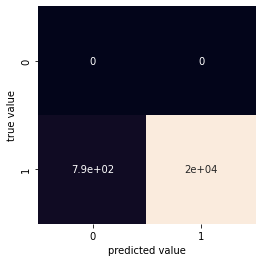

652/652 [==============================] - 3s 4ms/step - loss: 0.1020 - accuracy: 0.9853
NN:
accuracy(): 0.971038
CNN:
accuracy(): 0.963078
LSTM:
accuracy(): 0.961976


In [101]:
NN = metrics(model_NN, x=feature_scaled, y=label)
CNN = metrics(model_CNN, x=feature_scaled_10X3, y=label)
LSTM = metrics(model_LSTM, x=feature_scaled_10X3, y=label)
print("NN:\naccuracy(): %f" %NN[1] )
print("CNN:\naccuracy(): %f" %CNN[1] )
print("LSTM:\naccuracy(): %f" %LSTM[1] )